In [29]:
import numpy as np
import pandas as pd
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from numpy.random import sample
from collections import deque
import os

In [30]:
from torch.optim.lr_scheduler import ExponentialLR

def train(env, agent, episodes=100,batch_size = 256,training_mode = True, target_update_frequency=10):
    """
    在给定的环境中训练智能体。
    
    参数:
    env: 智能体所处的环境。
    agent: 在环境中学习和行动的智能体。
    episodes: 训练的轮数, 默认为100轮。
    batch_size: 每次训练时从记忆中随机抽取的样本数量, 默认为256。
    training_mode: 是否进行训练, 默认为True。如果为False, 则不进行训练, 只进行测试。
    target_update_frequency: 更新目标网络的频率, 默认为每10个回合更新一次。
    
    返回:
    agent: 训练后的智能体。
    info: 训练过程中收集的信息。
    """
    for e in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        round = 0
        info = []
        while not done:
            # 代理基于当前状态选择动作
            if round%20 == 0:
                # 代理基于当前状态选择动作
                action = agent.act(state)
            else:
                action = np.full((agent.fund_class),fill_value=2)
                
            round += 1
            # 执行选定的动作, 并接收下一个状态、奖励、是否完成标志
            next_state, reward, done, info_data = env.step(action)
            info.append(info_data)
            # 存储记忆
            agent.remember(state, action, reward, next_state, done)
            
            # 更新当前状态
            state = next_state
            
            # 累加奖励
            total_reward += reward
            
            if training_mode  and len(agent.memory) > batch_size:
                # 进行训练
                agent.replay(batch_size)

            if (round) % target_update_frequency == 0:
                agent.update_target_network()
            
        total_reward = total_reward  #/round
        #if training_mode:
        #    scheduler.step()  # 更新学习率
        # 每个 episode 结束时打印进度
        print(f"Episode {e + 1} of {episodes}, Total Reward: {total_reward}")
        # 可视化奖励
        env.visualize_rewards(e)
    if training_mode:
        # 如果想要保存模型权重
        agent.save("dqn_fund.pth")
    
    return agent,info

In [31]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

def load_data():
    """
    加载并处理基金数据和因子数据。
    
    该函数首先从Excel文件中读取股票和债券基金的数据, 然后合并这些数据并进行清洗。
    接着, 它读取并合并市场因子数据, 计算基金的收益率, 并对数据进行进一步的处理。
    最后, 它使用并行处理方法对每个基金进行回归分析, 并将结果保存到CSV文件中。
    
    Returns:
        pd.DataFrame: 包含所有处理后的基金数据和回归分析结果的DataFrame。
    """
    # 读取股票和债券基金数据, 合并基金数据
    data_1 = pd.read_excel("./root/fund_equity.xlsx")
    data_2 = pd.read_excel("./root/fund_bond.xlsx")
    fund_data = pd.concat((data_1, data_2),axis=0)

    # 选择特定列并重命名列名
    fund_data = fund_data[["代码","日期","收盘价(元)"]]
    fund_data.columns = ["Code","Date","Close"]

    # 获取交易日期和基金代码
    trading_dates = np.sort(fund_data["Date"].unique())
    fund_codes = fund_data["Code"].unique()

    # 处理收盘价数据
    x = fund_data["Close"].values 
    x = np.where(x>10,x/100,x)
    fund_data["Close"]  = x
    long_table = pd.DataFrame([(date,fundname) for date in trading_dates for fundname in fund_codes],columns=("Date","Code"))
    fund_data = pd.merge(left=fund_data,right=long_table,how="right",on=("Date","Code"))

    fund_data["NAN"] = fund_data["Close"]<1e-6
    Nan = fund_data.groupby("Code")["NAN"].mean()
    fund_codes = fund_codes[Nan<0.25]
    
    factors = pd.read_excel("./root/STK_MKT_THRFACDAY.xlsx")
    factors["Date"] = pd.to_datetime(factors["Date"])
    fund_data = pd.merge(fund_data, factors, on="Date",how="left")
    fund_data["Return"] = fund_data["Close"].transform(lambda x: np.log(x) - np.log(x.shift(1)))

    # 为缺失的收益率填充一个极小值
    fund_data["Return"] = fund_data["Return"].fillna(1e-7)

    # 定义一个函数来处理单个基金的数据
    def process_fund(code, trading_dates):
        """
        对单个基金进行数据处理和回归分析。
        
        Args:
            code (str): 基金代码。
            trading_dates (numpy.ndarray): 交易日期数组。
        
        Returns:
            list: 包含回归分析结果的列表。
        """
        sample = fund_data[fund_data['Code'] == code]
        sample = sample.sort_values(by='Date')
        X = sample[['CAPM', 'SMB', 'HML']].values
        y = sample['Return'].values
        dates = sample['Date'].values
        returns = sample['Return'].values
        
        results = []
        
        # 对每个交易日滚动计算回归模型
        for date_index, date in enumerate(trading_dates):
            # 截取到当前日期为止的数据
            valid_indices = np.where(dates <= date)[0]
            
            if valid_indices.size > 0:
                valid_X = X[valid_indices]
                valid_y = y[valid_indices]
                
                
                # 拟合模型
                ols = LinearRegression()
                ols.fit(valid_X, valid_y)

                
                drawdown = np.min(returns[valid_indices])
                drawdown = min(drawdown, 1e-7)
                # 保存结果
                list_data = [code, date, ols.coef_[0], ols.coef_[1], ols.coef_[2], ols.intercept_,drawdown]
                results.append(list_data)
        
        return results

    # 使用 joblib 并行处理
    num_jobs = -1  # 使用所有可用的核心
    results = Parallel(n_jobs=num_jobs)(delayed(process_fund)(code, trading_dates) for code in fund_codes)

    # 收集结果
    flat_results = [item for sublist in results for item in sublist]

    # 转换为 DataFrame
    result_df = pd.DataFrame(flat_results, columns=['Code', 'Date', 'CAPM_beta', 'SMB_beta', 'HML_beta', 'Alpha','MaxDrawdown'])
    result_df["Return"] = fund_data["Return"].shift(-1)
    result_df["Close"] = fund_data["Close"]
    result_df["LastClose"] = fund_data["Close"].shift(-1)
    result_df[["CAPM_beta","SMB_beta","HML_beta"]] = result_df[["CAPM_beta","SMB_beta","HML_beta"]] + 1e-7
    result_df = result_df.fillna(1e-7)
    result_df.to_csv("./root/Fund_Data.csv")
    return result_df

In [32]:

class DQN(nn.Module):
    """
    Deep Q-Network (DQN) 模型定义。
    
    参数:
    - state_size: 状态空间大小
    - action_size: 动作空间大小
    - asset_size: 资产类别数量
    - n: 输入状态的窗口大小, 默认为5
    """
    def __init__(self, state_size,action_size,asset_size, n=5):
        super(DQN, self).__init__()
        self.ln1 = nn.LayerNorm(n * state_size)
        self.fc1 = nn.Linear(n*state_size, 32)
        self.ln2 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, asset_size*action_size)
        self.dropout = nn.Dropout(p=0.33)  # 设置 dropout 概率

    def forward(self, x):
        """
        DQN模型的前向传播函数。
        
        参数:
        - x: 输入状态张量
        
        返回:
        - x: 经过网络处理后的张量
        """
        x = self.ln1(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # 应用 dropout
        x = self.ln2(x)
        assert not torch.isnan(x).any(), "FC1 output contains NaN values"
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)  # 应用 dropout
        #x = self.ln3(x)
        #assert not torch.isnan(x).any(), "FC2 output contains NaN values"
        #x = torch.relu(self.fc3(x))
        #assert not torch.isnan(x).any(), "FC3 output contains NaN values"
        x = self.fc4(x)
        return x

class DQNAgent:
    """
    DQN智能体定义。
    
    参数:
    - state_size: 状态空间大小
    - action_size: 动作空间大小
    - asset_size: 资产类别数量
    - n: 输入状态的窗口大小, 默认为5
    """
    def __init__(self, state_size, action_size,asset_size, n=5):
        self.state_size = state_size
        self.fund_class = asset_size
        self.action_size = action_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # 折扣因子
        self.epsilon = 1.0  # 探索率
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 0.01
        self.model = DQN(state_size,action_size,asset_size,n).to(self.device)
        weight_decay = 0.1 # L2 正则化系数
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=weight_decay)
        self.criterion = nn.MSELoss()
        self.window_size = n

        self.target_model = DQN(state_size, action_size, asset_size,n).to(self.device)
        self.update_target_network()

    def update_target_network(self):
        """
        更新目标网络的权重, 使其等于当前模型的权重。
        """
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        """
        存储经验到记忆池中。
        
        参数:
        - state: 当前状态
        - action: 执行的动作
        - reward: 获得的奖励
        - next_state: 下一个状态
        - done: 是否完成标志
        """
        # 确保 state 和 next_state 是一维数组
        state = state.flatten() if isinstance(state, np.ndarray) else state
        next_state = next_state.flatten() if isinstance(next_state, np.ndarray) else next_state

        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        根据当前状态选择动作。
        
        参数:
        - state: 当前状态
        
        返回:
        - actions: 选择的动作数组
        """
        if np.random.rand() <= self.epsilon:
            random_actions = np.random.choice([0, 1, 2], size=self.fund_class, p=[0.2, 0.2, 0.6])
            return random_actions
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        
        if torch.isnan(state).any():
            raise ValueError("State contains NaN values")
        
        with torch.no_grad():
            q_values = self.model(state)
        q_values = q_values.view(1, self.fund_class, self.action_size)  # 转换为二维张量
        actions = q_values.argmax(dim=2).squeeze().cpu().numpy()

        return actions

    def replay(self, batch_size):
        """
        经验回放, 用于训练模型。
        
        参数:
        - batch_size: 小批量大小
        """
        if len(self.memory) < batch_size:
            return
        minibatch_index = np.random.randint(0,high=len(self.memory),size=batch_size)
        minibatch = [self.memory[i] for i in minibatch_index]
        states, actions, rewards, next_states, dones = zip(*minibatch)

        # 检查 states 和 next_states 的形状
        #assert states.shape == (batch_size, self.window_size*self.state_size), f"States shape {states.shape} does not match expected {(batch_size, self.window_size*self.state_size)}"
        #assert next_states.shape == (batch_size, self.window_size*self.state_size), f"Next states shape {next_states.shape} does not match expected {(batch_size, self.window_size*self.state_size)}"

        # 确保 states 和 next_states 是二维数组
        states = np.array(states)
        next_states = np.array(next_states)
        
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device)  # 调整为与 states 相同的维度
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device).unsqueeze(1)
        
        # 确保 actions 是二维张量
        actions = actions.squeeze()  # 移除多余的维度
        
        # 创建 batch_indices 张量
        batch_indices = torch.arange(batch_size, device=self.device).unsqueeze(1)
        
        # 将 actions 转换为适合 gather 的形状
        actions = torch.cat([batch_indices, actions], dim=1)
        
        current_q_values = self.model(states)
        selected_q_values = current_q_values.gather(1, actions[:, 1].unsqueeze(1))
        
        max_next_q_values = self.target_model(next_states).max(1)[0].unsqueeze(1)
        expected_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values
        
        loss = self.criterion(selected_q_values, expected_q_values)
        assert not torch.isnan(loss), "Loss contains NaN values"
        self.optimizer.zero_grad()
        loss.backward()
        #grads = [param.grad for param in self.model.parameters()]
        #for grad in grads:
        #    assert not torch.isnan(grad).any(), "Gradient contains NaN values"
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, filename):
        """
        保存模型权重到文件。
        
        参数:
        - filename: 保存文件名
        """
        torch.save(self.model.state_dict(), filename)

    def load(self, filename):
        """
        从文件加载模型权重。
        
        参数:
        - filename: 加载文件名
        """
        self.model.load_state_dict(torch.load(filename, map_location=self.device))

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

class MultiFundInvestmentEnv:
    """
    多基金投资环境类, 用于模拟基金投资过程。
    
    参数:
    - data: 基金数据, 包含基金代码、日期、收盘价等信息。
    - columns: 数据列名, 用于指定数据中的特定列。
    - initial_amount: 初始投资金额, 默认为10000。
    - transaction_cost: 交易成本, 默认为0.01。
    - window_size: 观测窗口大小, 默认为1。
    """
    def __init__(self, data,columns, initial_amount=10000, transaction_cost=0.01, window_size = 1):
        # 初始化环境参数
        self.data = data
        self.columns = columns
        self.dates = data.index.get_level_values('Date').unique()
        self.funds = data.index.get_level_values('Code').unique()
        self.initial_amount = initial_amount
        self.transaction_cost = transaction_cost
        self.current_date = 0
        self.current_fund = 0
        self.cash = initial_amount  # 初始现金
        self.portfolio_value = initial_amount  # 总资产
        self.holdings = {fund: 0 for fund in self.funds}
        self.previous_holdings_value = initial_amount  # 上一步持仓价值
        self.previous_close_prices = {}  # 上一步收盘价
        self.rewards = []
        self.returns = []
        self.values = []
        self.smoothed_reward = 1e-7
        self.window_size = window_size
        
        # 观测空间：每个基金的状态（如收益率、波动率等）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(self.funds) * len(self.columns),), dtype=np.float32)
        
        # 动作空间：每个基金的投资比例（例如买入/卖出）
        self.action_space = spaces.MultiDiscrete([3] * len(self.funds))  # 假设每个基金的动作空间为买、卖、持有
        
    def reset(self):
        """
        重置环境到初始状态。
        
        返回:
        - observation: 初始观测值。
        """
        # 重置环境到初始状态
        self.current_date = 0
        self.current_fund = 0
        self.portfolio_value = self.initial_amount
        self.cash = self.initial_amount
        self.holdings = {fund: 0 for fund in self.funds}
        self.rewards = []
        self.returns = [1e-7]
        self.values = []
        self.smoothed_reward = 1e-7
        return self._get_observation(n= self.window_size)
    
    def step(self, action):
        """
        执行一步操作。
        
        参数:
        - action: 动作列表, 表示对每个基金的操作。
        
        返回:
        - observation: 新的观测值。
        - reward: 奖励。
        - done: 是否完成。
        - info: 信息字典, 包含每个基金的代码、持仓、收盘价和动作。
        """
        # 执行一步操作
        #if not isinstance(action, list) or len(action) != len(self.funds):
        #    raise ValueError("Action must be a list of the same length as the number of funds.")
        self._execute_action(action)
        self.current_date += 1
        self.current_fund = (self.current_fund + 1) % len(self.funds)
        
        
        # 计算新的观测值、奖励、是否完成以及信息字典
        observation = self._get_observation(n = self.window_size)
        

        reward = self._calculate_reward()
        # 更新 previous_holdings_value 为最新的 portfolio_value
        self.previous_holdings_value = self.portfolio_value
        # 记录奖励
        #log_return = np.log(self.portfolio_value + 1e-7) - np.log(self.previous_holdings_value+ 1e-7)
        #self.rewards.append(log_return)

        done = ((self.current_date >= (len(self.dates) - 1)) or (self.portfolio_value  <= 0))
        info = {(fund,self.holdings[fund],self.data.loc[(self.dates[self.current_date], fund), 'Close']) for fund in self.funds}
        info = pd.DataFrame(info,columns=["Code","Holdings","Close"])
        info["Action"] = action
         
        return observation, reward, done, info
    
    def _execute_action(self, action):
        """
        执行具体的投资动作。
        
        参数:
        - action: 动作列表, 表示对每个基金的操作。
        """
        date_time = self.dates[self.current_date]
        # 更新前一时刻的持仓价值和收盘价
        self.previous_holdings_value = self.portfolio_value
        self.close_prices = {fund: self.data.loc[(date_time, fund), 'Close'] for fund in self.funds}
        # 根据动作更新持仓
        for fund, act in enumerate(action):
            fund_name = self.funds[fund]
            last_close = self.data.loc[(date_time, fund_name), 'LastClose']
            if fund_name not in self.holdings:
                # 如果基金名称不在 holdings 中, 则添加一个键并初始化为 0
                self.holdings[fund_name] = 0

            try:
                close_price = self.data.loc[(date_time, fund_name), 'Close']
            except KeyError:
                close_price = 1e-7  # 或者设置其他默认值
            
            #if (close_price<= 1e-6):
            #    act = 2    
            
            if (act == 0) and (close_price> 1e-6):  # 买入
                self.buy(0.025,close_price,fund_name)
            
            
            elif (act == 1) and (close_price> 1e-6):  # 卖出
                self.sell(0.2,close_price=close_price,fund_name=fund_name)
            

            
            if (close_price<= 0.2) and (last_close <= 0.2):
                self.sell(1,close_price,fund_name) 
            
        # 更新持仓价值
        self.portfolio_value = self._calculate_value()
        self.values.append(self.portfolio_value)

    def buy(self,amount,close_price,fund_name):   
        """
        买入指定基金。
        
        参数:
        amount (float): 买入金额比例。
        close_price (float): 基金的收盘价。
        fund_name (str): 基金名称。
        """
        amount_to_invest  = min(self.cash * amount , self.cash)  # 确保不会超过现有现金
        amount_to_invest = max(amount_to_invest, 0)

        shares_to_buy = int(amount_to_invest / close_price)
        self.holdings[fund_name] += shares_to_buy
        self.cash -= amount_to_invest * (1 + self.transaction_cost)
    
    def sell(self,amount,close_price,fund_name):
        """
        卖出指定基金。
        
        参数:
        amount (float): 卖出份额比例。
        close_price (float): 基金的收盘价。
        fund_name (str): 基金名称。
        """
        amount_to_sell = np.floor(self.holdings[fund_name] * amount)  # 假设卖出份额为当前持有份额的25%
        shares_to_sell = min(amount_to_sell, self.holdings[fund_name])  # 确保不会卖出比持有的多 
        shares_to_sell = max(shares_to_sell, 0)
                
        self.holdings[fund_name] -= shares_to_sell
        self.cash += shares_to_sell * close_price * (1 - self.transaction_cost)
                
    def _get_observation(self, n=5):  # n 表示包含当前日期在内的前 n 天数据
        """
        获取当前及过去几天的基金状态。
        
        参数:
        n (int): 包含当前日期在内的天数。
        
        返回:
        np.array: 展平后的数据数组。
        """
        # 获取当前日期及之前 n 天内所有基金的状态
        start_date_index = max(0, self.current_date - n + 1)
        end_date_index = self.current_date
        
        # 获取指定范围内的所有日期
        dates_range = self.dates[start_date_index:end_date_index + 1]
        
        # 根据日期范围获取数据
        current_data = self.data.loc[pd.IndexSlice[dates_range, :], self.columns]

        # 计算需要填充的天数
        num_days_to_fill = n - len(dates_range)

        # 创建填充数据
        fill_data = np.full((num_days_to_fill*len(self.funds), len(self.columns)), 1e-7)
        if num_days_to_fill > 0:
            current_data = pd.concat([pd.DataFrame(fill_data, columns=self.columns), current_data], axis=0)

        # 确保 current_data 的形状为 (n, state_size)
        assert current_data.shape == (n*len(self.funds), len(self.columns)), f"Current data shape {current_data.shape} does not match expected {(n*len(self.funds), len(self.columns))}"
        # 将数据展平为一维数组
        flattened_data = current_data.values.flatten()

        return flattened_data
    
    def _calculate_value(self):
        """
        计算当前投资组合的价值。
        
        返回:
        float: 投资组合的价值。
        """
        holding_values = np.array(list(self.holdings.values()))
        close_prices_values = np.array(list(self.close_prices.values()))
        current_holdings_value = np.sum(np.array(holding_values) * np.array(close_prices_values))   
        return current_holdings_value   + self.cash  # 包括现金

    def _calculate_reward(self):

        """
        计算并返回奖励。
        
        返回:
        float: 计算得到的奖励。
        """
        log_return = np.log(self.portfolio_value + 1e-7) - np.log(self.previous_holdings_value+ 1e-7)

        self.returns.append(log_return)
        # 使用标准化处理
        if len(self.returns) <= 2:
            norm_reward = log_return
        else:
            mean_return = np.mean(self.returns)
            std_return = np.std(self.returns)
            norm_reward = (log_return - mean_return) / (std_return + 1e-7)  # 防止除零错误

        # 使用EMA平滑
        if len(self.returns) <= 2:
            smoothed_reward = norm_reward
        else:
            alpha = 0.25  # 平滑因子
            smoothed_reward = alpha * norm_reward + (1 - alpha) * self.smoothed_reward
        self.smoothed_reward = smoothed_reward
        return log_return
    
    def visualize_rewards(self,eps):
        """
        可视化奖励。
            
        参数:
        eps (int): 当前的回合数。
        """
        fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(16, 10))
        y_1 = np.array(self.returns)
        ax1.plot(self.dates,y_1)
        ax1.hlines(y = 0,xmin=self.dates.min(),xmax=self.dates.max(),colors=["red"])
        ax1.set_xlabel('Trading Dates')
        ax1.set_ylabel('Portfolio Returns')
        # 设置x轴的日期范围
        ax1.set_xlim([self.dates.min(), self.dates.max()])
        ax1.set_ylim([y_1.min(), y_1.max()])
        ax1.xaxis.set_major_locator(ticker.MaxNLocator(12))
        ax1.set_title('Portfolio Returns Over Time')

        y_2 = np.array(self.values)
        ax2.plot(self.dates[1:],y_2)
        ax2.hlines(y = self.initial_amount,xmin=self.dates[1:].min(),xmax=self.dates[1:].max(),colors=["red"])
        ax2.set_xlabel('Trading Dates')
        ax2.set_ylabel('Portfolio Value')
        ax2.set_xlim([self.dates[1:].min(), self.dates[1:].max()])
        ax2.set_ylim([y_2.min(), y_2.max()])
        ax2.xaxis.set_major_locator(ticker.MaxNLocator(12))
        ax2.set_title('Portfolio Value Over Time')

        plt.legend()
        plt.show()
        fig.savefig(f"./root/{eps}.png")

In [34]:
from sklearn.model_selection import train_test_split
def split_data(data):
    # 获取所有唯一的交易日期并按顺序排序
    trading_dates = np.sort(data["Date"].unique())
    # 获取所有唯一的基金代码
    fund_codes = data["Code"].unique()

    # 将交易日期分为训练集日期和验证集日期, 验证集占20%, 不打乱顺序
    train_dates, valid_dates = train_test_split(trading_dates, test_size=0.2, shuffle=False)
    # 根据日期将数据分为训练集和验证集
    train_data,valid_data = data[data['Date']<=train_dates[-1]],data[data["Date"]>=valid_dates[0]]

    # 选择训练集中需要的列, 并设置日期和基金代码为索引
    train_data = train_data[["Date","Code","CAPM_beta","SMB_beta","HML_beta","Alpha","Return","Close",'MaxDrawdown','LastClose']]
    train_data = train_data.set_index(["Date","Code"])
    # 选择验证集中需要的列, 并设置日期和基金代码为索引
    valid_data = valid_data[["Date","Code","CAPM_beta","SMB_beta","HML_beta","Alpha","Return","Close",'MaxDrawdown','LastClose']]
    valid_data = valid_data.set_index(["Date","Code"])

    valid_data["Nan"] = valid_data["Close"]<1e-6
    train_data["Nan"] = train_data["Close"]<1e-6
    fund_codes = fund_codes[(train_data.groupby("Code")["Nan"].mean()<0.25) & (valid_data.groupby("Code")["Nan"].mean()<0.25)]


    # 初始化空DataFrame来存储过滤后的数据
    train_data_filtered = pd.DataFrame()
    valid_data_filtered = pd.DataFrame()
    # 对于每一个基金代码，使用xs方法提取对应的数据，然后拼接到总的DataFrame中
    for code in fund_codes:
        train_data_code = train_data.xs(code, level='Code', axis=0)
        valid_data_code = valid_data.xs(code, level='Code', axis=0)
        train_data_code[train_data_code["Nan"]] = np.nan
        valid_data_code[valid_data_code["Nan"]] = np.nan
        train_data_code = train_data_code.interpolate(method='linear')
        valid_data_code = valid_data_code.interpolate(method='linear')
        train_data_code.fillna(method="ffill",inplace=True)
        valid_data_code.fillna(method="ffill",inplace=True)
        train_data_code.fillna(1e-7,inplace=True)
        valid_data_code.fillna(1e-7,inplace=True)
        train_data_code["Code"],valid_data_code["Code"] = code,code
        train_data_code["Date"] = train_data_code.index.copy()
        valid_data_code["Date"] = valid_data_code.index.copy()
        
        train_data_filtered = pd.concat([train_data_filtered, train_data_code])
        valid_data_filtered = pd.concat([valid_data_filtered, valid_data_code])

    # 将收益率和最大回撤率乘以100进行缩放
    train_data_filtered[["Return","MaxDrawdown"]] *= 100
    valid_data_filtered[["Return","MaxDrawdown"]] *= 100

    train_data = train_data_filtered
    valid_data = valid_data_filtered
    train_data.set_index(["Date","Code"],inplace=True)
    valid_data.set_index(["Date","Code"],inplace=True)



    return train_data,valid_data,fund_codes

In [35]:

# 检查是否已经下载好了数据
if os.path.exists('./root/Fund_Data.csv'):
    # 如果数据已下载, 则读取本地CSV文件
    data = pd.read_csv('./root/Fund_Data.csv')
else:
    # 如果数据未下载, 则调用load_data函数加载数据
    data = load_data()
train_data, valid_data, fund_codes = split_data(data)

/tmp/ipykernel_2276/3945648889.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2276/3945648889.py:32: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_2276/3945648889.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2276/3945648889.py:33: FutureWarning:

Setting an item of incompatibl

Episode 1 of 4, Total Reward: -0.013276626765554411


/tmp/ipykernel_2276/1404252164.py:279: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



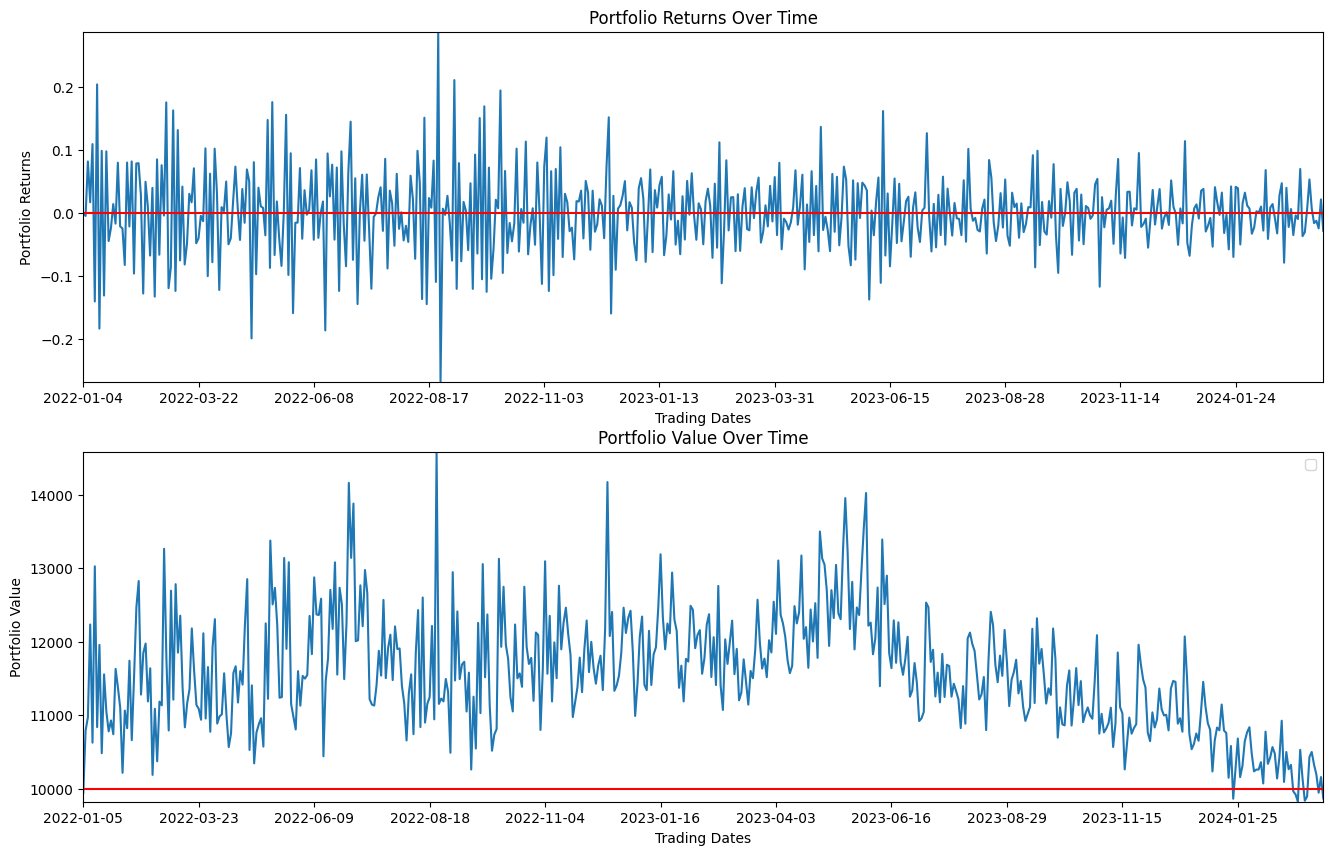

Episode 2 of 4, Total Reward: 0.13823678691109365


/tmp/ipykernel_2276/1404252164.py:279: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



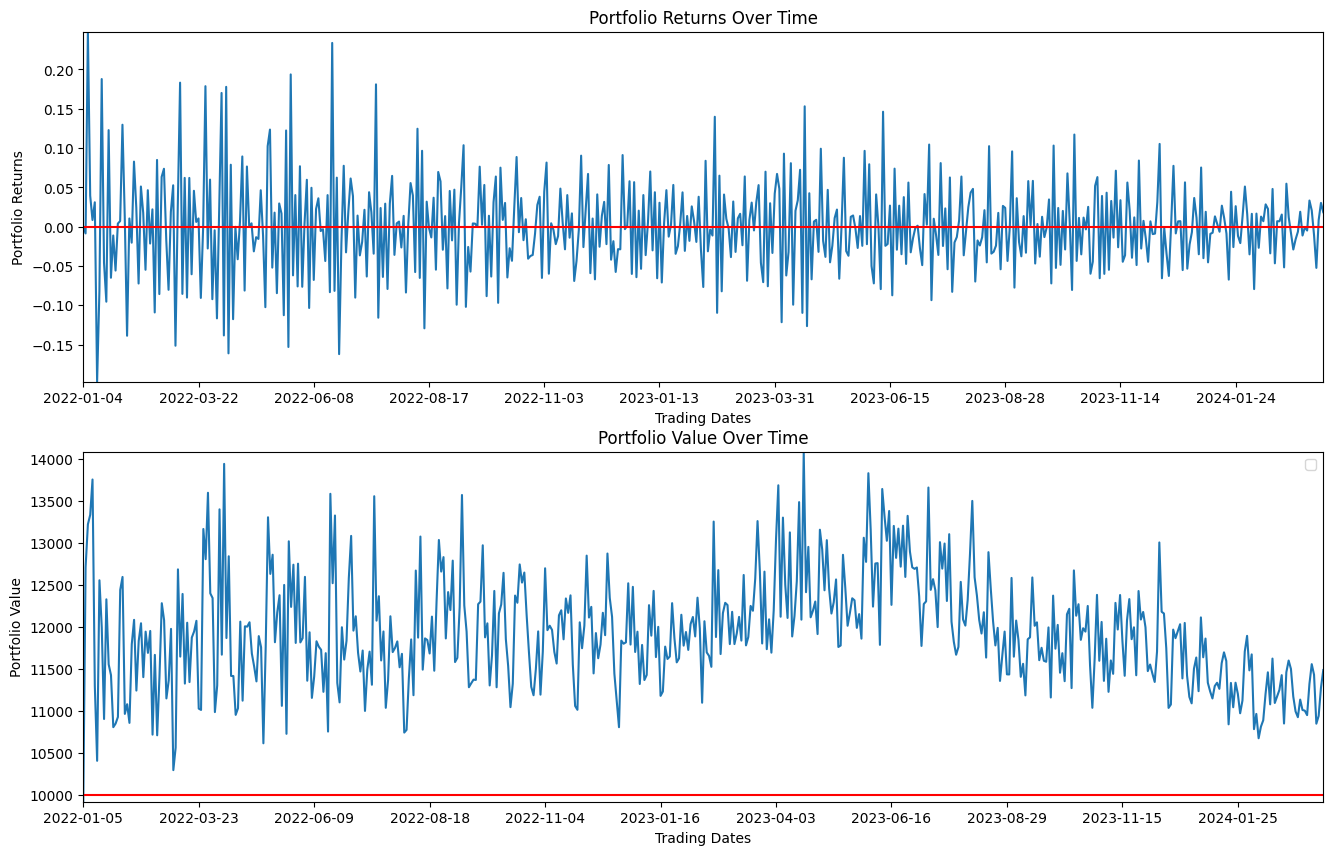

Episode 3 of 4, Total Reward: 0.05696362424901835


/tmp/ipykernel_2276/1404252164.py:279: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



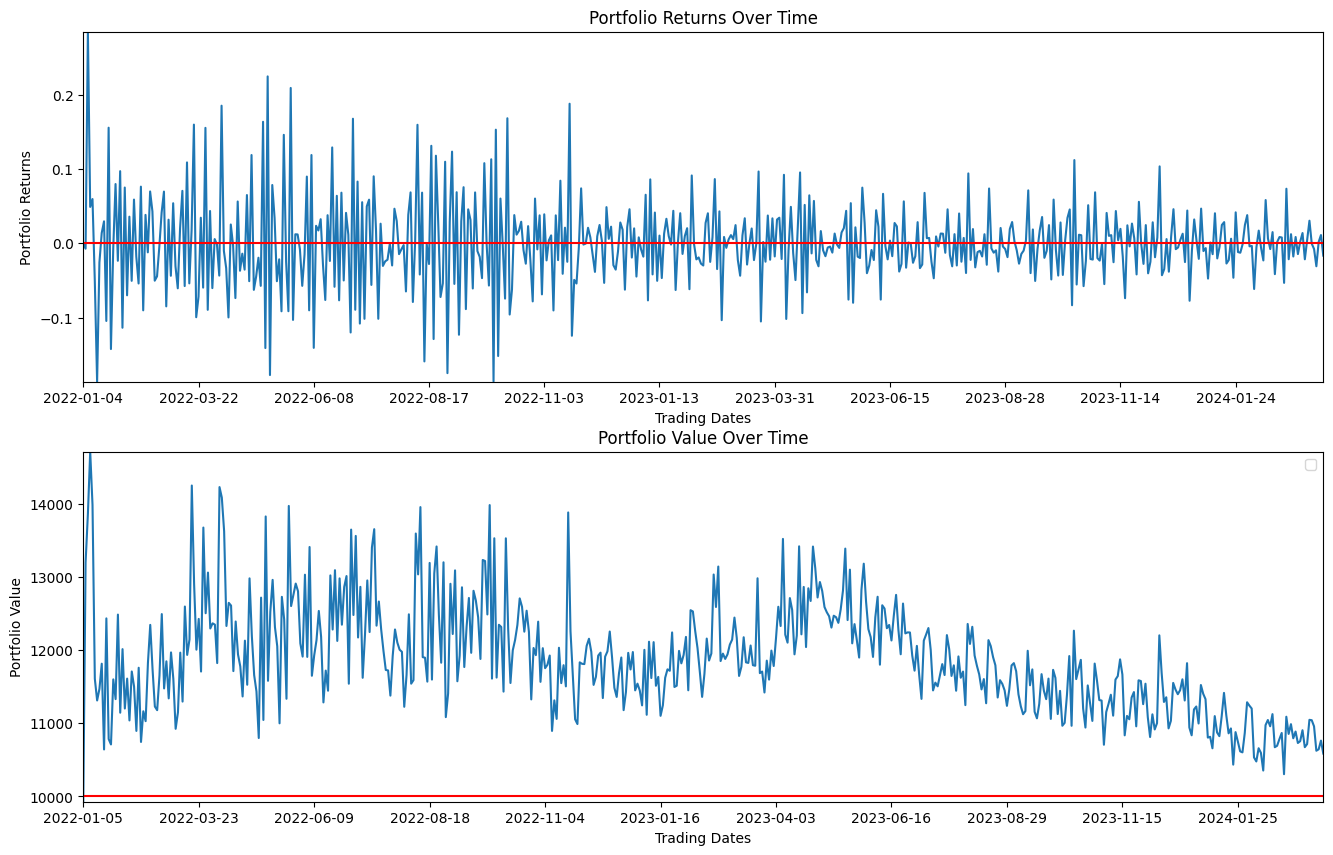

Episode 4 of 4, Total Reward: 0.23540693590779505


/tmp/ipykernel_2276/1404252164.py:279: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



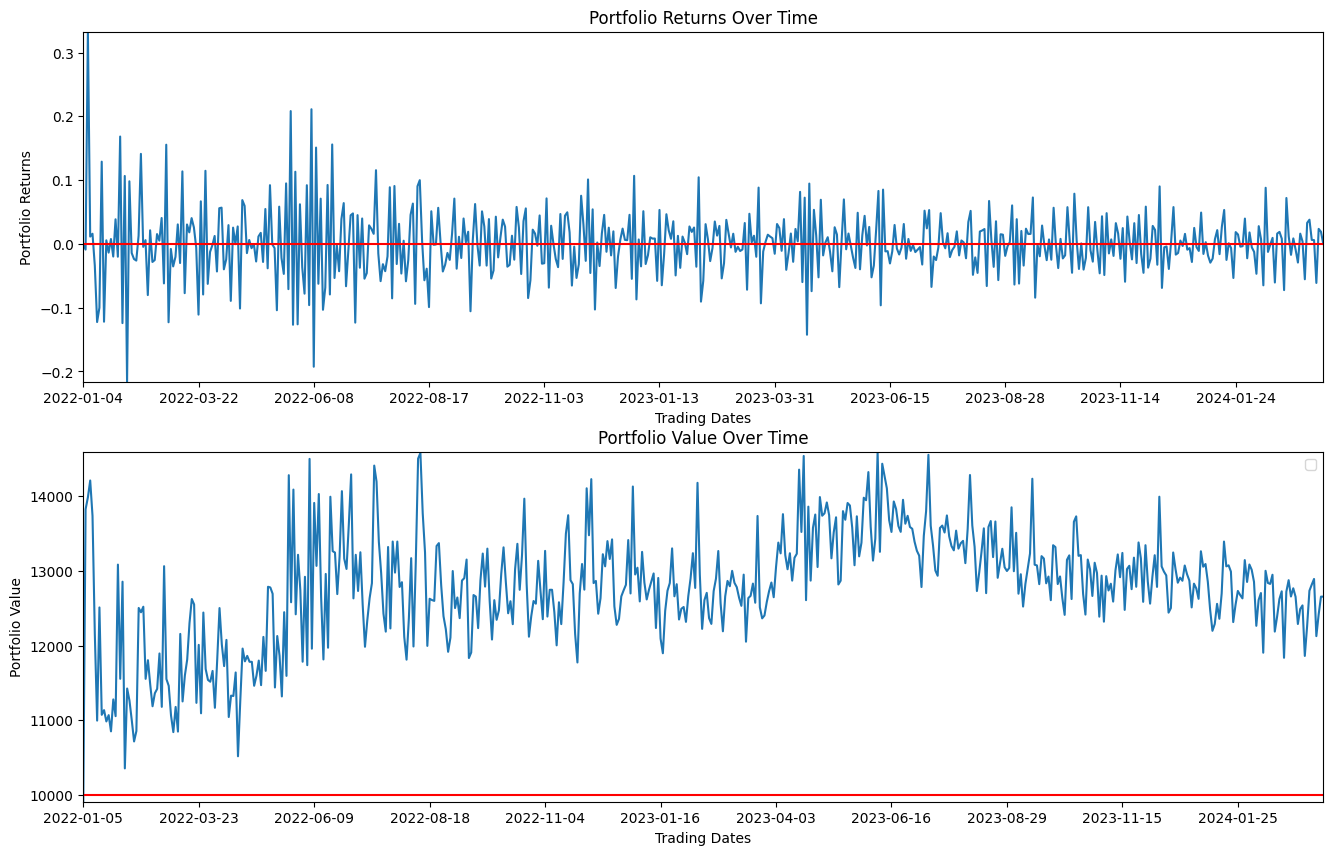

Episode 1 of 1, Total Reward: 0.12912124304498818


/tmp/ipykernel_2276/1404252164.py:279: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



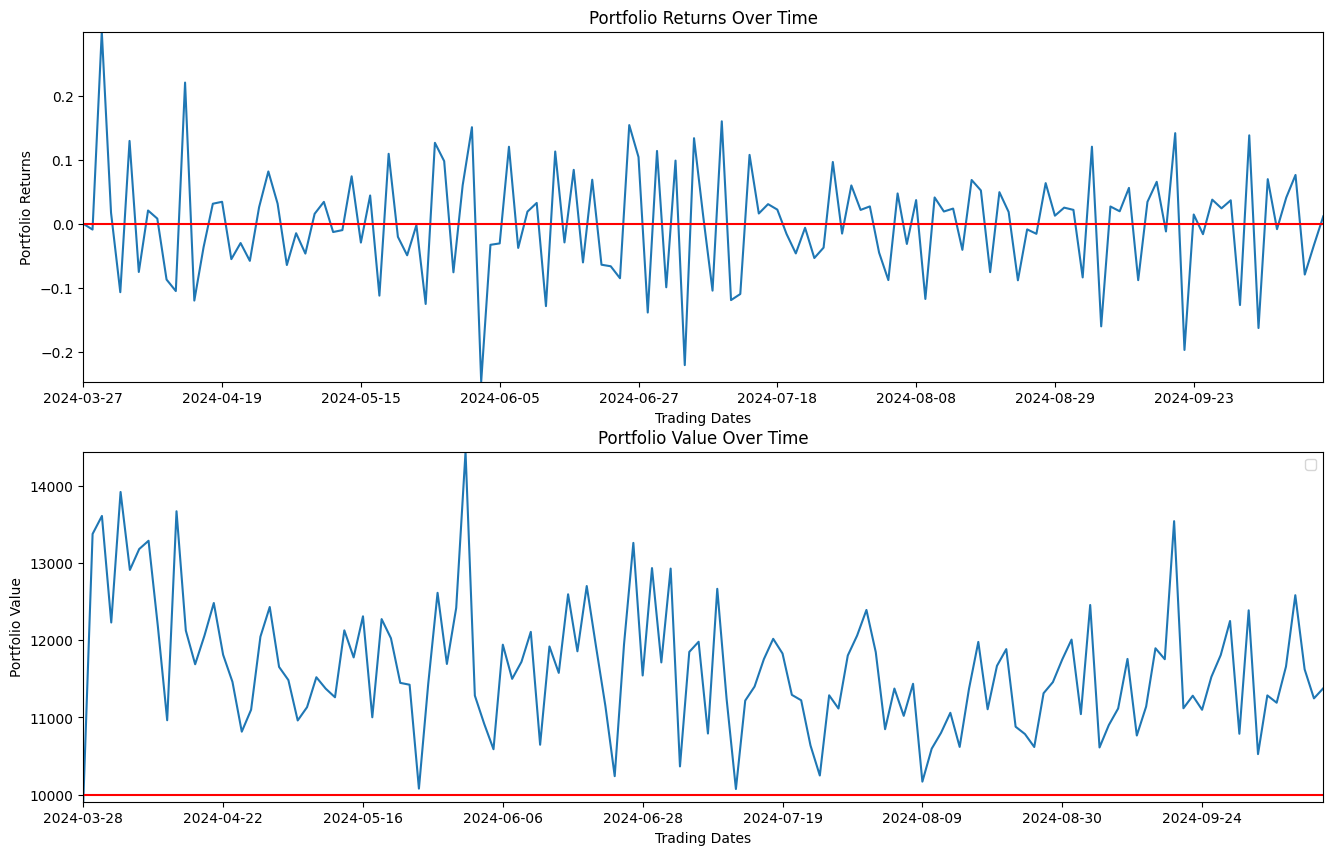

In [36]:
# 设置窗口大小, 用于确定环境中的观察窗口
window_size = 10
batch_size = 512
col_list = ["CAPM_beta","SMB_beta","HML_beta","Alpha","Return",'MaxDrawdown','LastClose']
# 初始化训练环境, 包含多个基金的投资环境, 用于训练模型
env_train = MultiFundInvestmentEnv(data=train_data,columns=col_list, 
                                   initial_amount=10000, transaction_cost=0.001, window_size = window_size)

# 初始化验证环境, 与训练环境相似, 用于验证模型的性能
env_valid = MultiFundInvestmentEnv(data=valid_data,columns=col_list,
                                    initial_amount=10000, transaction_cost=0.001, window_size = window_size)

# 初始化 DQN 代理
state_size = env_train.observation_space.shape[0]
action_size = env_train.action_space.nvec[0]  # 假设所有基金的动作空间相同
agent = DQNAgent(state_size, action_size,asset_size = len(fund_codes),n = window_size)

# 使用训练环境对代理进行训练
agent,info_train = train(env_train, agent, episodes = 4,batch_size = batch_size)

# 使用验证环境对代理进行测试, 不进行训练
valid,info_valid = train(env_valid, agent, episodes = 1,batch_size = batch_size,training_mode=False)

# 将训练信息保存到数据框中, 以便后续分析
df_train_info = pd.concat(info_train,ignore_index=True)

# 将验证信息保存到数据框中, 以便后续分析
df_valid_info = pd.concat(info_valid,ignore_index=True)

# 将训练信息导出到CSV文件
df_train_info.to_csv("./root/df_train_info.csv",index=False)

# 将验证信息导出到CSV文件
df_valid_info.to_csv("./root/df_valid_info.csv",index=False)

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def plot_info(data, code):
    """
    根据给定的数据和代码, 生成一个包含两个子图的图表。
    上方子图显示了指定代码的数据的收盘价折线图, 下方子图显示其持股量的柱状图。

    参数:
    data (DataFrame): 包含市场数据的DataFrame, 其中必须包括"Code", "Close", 和 "Holdings" 列。
    code (str): 要绘制的特定代码。

    返回:
    Figure: 一个Plotly Figure对象, 包含两个子图。
    """
    # 筛选出与给定代码匹配的数据
    sample = data[data["Code"]==code]
    sample["Return"] = sample["Close"]*sample["Holdings"]
    sample["Return"] = sample["Return"].pct_change()
    # 生成x轴数据, 用于表示数据点的位置
    x = [i for i in range(len(sample))]
    
    # 创建一个包含两个子图的图表, 共享x轴, 设置较小的垂直间距
    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08,
        specs=[[{"type": "scatter"}],
              [{"type": "bar"}],[{"type": "scatter"}]],
              x_title="交易日",
             row_titles=["收盘价","持仓量","持仓收益"]
              
    )
    
    # 向图表中添加折线图, 显示收盘价
    fig.add_trace(
        go.Scatter(
            x=x,
            y=sample["Close"],
            mode="lines",
            name="Close Prices"
        ),
        row=1, col=1
    )
    
    # 向图表中添加柱状图, 显示持股量
    fig.add_trace(
        go.Bar(name='Holdings', x=x, y=sample["Holdings"]),
        row=2, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=x,
            y=sample["Return"],
            mode="lines",
            name="Holding Return"
        ),
        row=3, col=1
    )
    
    # 返回构建好的图表
    return fig

In [2]:
import pandas as pd
df_train_info = pd.read_csv("./root/df_train_info.csv")
df_valid_info = pd.read_csv("./root/df_valid_info.csv")

In [25]:
plot_info(df_valid_info,"159780.OF")

C:\Users\22109\AppData\Local\Temp\ipykernel_2344\1798381686.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\22109\AppData\Local\Temp\ipykernel_2344\1798381686.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
df_valid_info.groupby("Code").max().sort_values("Holdings",ascending=False).head(20)

,Holdings,Close,Action
Code,,,
159622.OF,328.0,5.002,2
159780.OF,316.0,7.252,2
160633.OF,238.0,6.812,2
159691.OF,235.0,7.078,2
159511.OF,220.0,1.515,2
159838.OF,218.0,1.375,2
159647.OF,207.0,4.942,2
159538.OF,200.0,5.653,2
161816.OF,199.0,2.807,2


In [26]:
plot_info(df_train_info,"159824.OF")

C:\Users\22109\AppData\Local\Temp\ipykernel_2344\1798381686.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\22109\AppData\Local\Temp\ipykernel_2344\1798381686.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
df_train_info.groupby("Code").max().sort_values("Holdings",ascending=False).head(20)

,Holdings,Close,Action
Code,,,
159667.OF,2355.0,6.546,2
160638.OF,325.0,2.508,2
159824.OF,307.0,7.472,2
160127.OF,302.0,7.140,2
159976.OF,300.0,4.374,2
163110.OF,300.0,7.361,2
161816.OF,297.0,7.408,2
160635.OF,256.0,6.031,2
163116.OF,254.0,6.532,2
